# <font color = 'Orange'>GeoX</font>
---
Nome: Murilo H. Gomes

## <font color = 'tomato'>Ferramentas</font>

### <font color = 'tomato'>Instalação de Pacotes</font>

In [ ]:
pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
pip install pycausalimpact

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### <font color = 'tomato'>Bibliotecas e Funções</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from causalimpact import CausalImpact

# Funções de similaridade
def numSim(index1, index2):
  if index1 == 0 and index2 == 0:
    return 0.0
  else:
    return 1 - np.absolute(index1 - index2)/(np.absolute(index1) + np.absolute(index2))

def peakSim(index1, index2):
  if index1 == 0 and index2 == 0:
    return 0
  else:
    return 1 - np.absolute(index1 - index2)/(2*np.maximum(np.absolute(index1),np.absolute(index2)))

def timeSeries_tnumSim(iterable1, iterable2):

  n = len(iterable1)
  if(n != len(iterable2)):
    print("The size of interables don't matches.")
  else:

    Sum = 0
    for i in range(n):

      Sum += numSim(iterable1[i],iterable2[i])
      #print(Sum)

    return Sum/n

def timeSeries_rtnumSim(iterable1, iterable2):

  n = len(iterable1)
  if(n != len(iterable2)):
    print("The size of interables don't matches.")
  else:

    Sum = 0
    for i in range(n):

      Sum += numSim(iterable1[i],iterable2[i])**2
      #print(Sum)

    return np.sqrt(Sum/n)

def timeSeries_tpeakSim(iterable1, iterable2):

  n = len(iterable1)
  if(n != len(iterable2)):
    print("The size of interables don't matches.")
  else:

    Sum = 0
    for i in range(n):

      Sum += peakSim(iterable1[i],iterable2[i])
      #print(Sum)

    return Sum/n


## <font color = 'tomato'>Base de dados</font>

In [ ]:
dados = pd.read_csv('path')
#dados.rename(columns = {'Unnamed: 0':'COD.'}, inplace = True)
dados = dados.drop(['Unnamed: 0'],axis = 1)

dados['DATA'] = pd.to_datetime(dados['DATA'])
dados = dados.sort_values(by='DATA',ascending=True)
dados.head()

,DATA,city,meta25
0,2022-04-01,Praia Grande,9
200,2022-04-01,Campo Grande,0
199,2022-04-01,Feira de Santana,0
198,2022-04-01,Viamao,0
197,2022-04-01,Sertaozinho,0


In [ ]:
dados.dtypes

DATA      datetime64[ns]
city              object
meta25             int64
dtype: object

## <font color = 'tomato'>Metodologia</font>

Com efeito de que desejamos avaliar a significância estatística de um fenômeno nas vendas provocado pela campanha de marketing em uma região específica - cidade de Salvador. Temos que utilizaremos do conceito de GeoX, isto é, utilizar outra região geográfica similar para testar a significância estatística do fenômeno observado. A similaridade se faz necessária, pois tendo ocorrido o fenômeno em apenas uma região geográfica a região distinta mais similar cumprirá o papel de ser referência para o que poderia ter ocorrido caso o fenômeno não tivesse sido observado.

No caso estudado, as regiões geográficas são cidades cujas informações foram coletadas através da ferramente de posicionamento global do tiktok onde a campanha de marketing ocorreu. Porém, na época de observações há inconsistência nas medidas de posicionamento tomadas em pequenas cidades. Logo, tomaremos a medida de similaridade apenas nas capitais estaduais e cidades com mais de 500 mil de habitantes, já que Salvador possui uma população aproximada de 1,8 milhão de habitantes.

### <font color = 'tomato'>Filtrando cidades de interesse</font>

Para encontrar as cidades com mais de 500 mil habitantes precisaremos cruzar as informações da base de dados com as informações fornecidades no último censo do IBGE (IBGE 2010). A seguir temos a base de dados fornecidade no site: https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?=&t=resultados.

In [ ]:
popEstimada = pd.read_csv("/content/POP2021_20220905 - Municípios.csv",
                          skiprows = [0],
                          converters={'COD. UF': str,
                                      'COD. MUNIC':str}
                          )
popEstimada.rename(columns = {' POPULAÇÃO ESTIMADA':'POP. ESTIMADA',
                              'NOME DO MUNICÍPIO': 'NOME MUNIC'},
                               inplace = True)

popEstimada = popEstimada.drop(['COD. UF', 'COD. MUNIC'], axis = 1)
popEstimada = popEstimada.dropna(axis = 0)
popEstimada.head()

,UF,NOME MUNIC,POP. ESTIMADA
0,RO,Alta Floresta D'Oeste,22.516
1,RO,Ariquemes,111.148
2,RO,Cabixi,5.067
3,RO,Cacoal,86.416
4,RO,Cerejeiras,16.088


In [ ]:
popEstimada.dtypes

UF               object
NOME MUNIC       object
POP. ESTIMADA    object
dtype: object

In [ ]:
# Transformando valores str na coluna da população para float
popEstimada["POP. ESTIMADA"]=popEstimada["POP. ESTIMADA"].str.replace('.','')
popEstimada["POP. ESTIMADA"]=popEstimada["POP. ESTIMADA"].str.extract('(\d+)', expand=False) # fiz o regex da forma certa?
popEstimada['POP. ESTIMADA'] = popEstimada['POP. ESTIMADA'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [ ]:
popEstimada.head()

,UF,NOME MUNIC,POP. ESTIMADA
0,RO,Alta Floresta D'Oeste,22516.0
1,RO,Ariquemes,111148.0
2,RO,Cabixi,5067.0
3,RO,Cacoal,86416.0
4,RO,Cerejeiras,16088.0


In [ ]:
cidadesFiltro = popEstimada.loc[popEstimada['POP. ESTIMADA'] >= float(500000)]

In [ ]:
len(list(cidadesFiltro['NOME MUNIC'].unique()))

49

In [ ]:
cidadesFiltro['NOME MUNIC'].unique()

array(['Porto Velho', 'Manaus', 'Ananindeua', 'Belém', 'Macapá',
       'São Luís', 'Teresina', 'Fortaleza', 'Natal', 'João Pessoa',
       'Jaboatão dos Guararapes', 'Recife', 'Maceió', 'Aracaju',
       'Feira de Santana', 'Salvador', 'Belo Horizonte', 'Contagem',
       'Juiz de Fora', 'Uberlândia', 'Serra', 'Vila Velha',
       'Belford Roxo', 'Campos dos Goytacazes', 'Duque de Caxias',
       'Niterói', 'Nova Iguaçu', 'Rio de Janeiro', 'São Gonçalo',
       'Campinas', 'Guarulhos', 'Osasco', 'Ribeirão Preto', 'Santo André',
       'São Bernardo do Campo', 'São José dos Campos', 'São Paulo',
       'Sorocaba', 'Curitiba', 'Londrina', 'Florianópolis', 'Joinville',
       'Caxias do Sul', 'Porto Alegre', 'Campo Grande', 'Cuiabá',
       'Aparecida de Goiânia', 'Goiânia', 'Brasília'], dtype=object)

In [ ]:
cidadesFiltradas = dados[dados['city'].isin(list(cidadesFiltro['NOME MUNIC']))]
cidadesFiltradas

,DATA,city,meta25
200,2022-04-01,Campo Grande,0
199,2022-04-01,Feira de Santana,0
202,2022-04-01,Londrina,0
216,2022-04-01,Juiz de Fora,0
205,2022-04-01,Aracaju,6
...,...,...,...
39665,2022-07-31,Vila Velha,0
39661,2022-07-31,Osasco,0
39730,2022-07-31,Natal,0
39689,2022-07-31,Salvador,0


In [ ]:
len(cidadesFiltradas['city'].unique())

29

In [ ]:
cidadesFiltradas['city'].unique()

array(['Campo Grande', 'Feira de Santana', 'Londrina', 'Juiz de Fora',
       'Aracaju', 'Vila Velha', 'Campinas', 'Joinville', 'Natal',
       'Teresina', 'Porto Alegre', 'Ananindeua', 'Belford Roxo',
       'Contagem', 'Recife', 'Guarulhos', 'Fortaleza', 'Rio de Janeiro',
       'Salvador', 'Belo Horizonte', 'Curitiba', 'Sorocaba',
       'Duque de Caxias', 'Osasco', 'Manaus', 'Serra', 'Porto Velho',
       'Campos dos Goytacazes', 'Caxias do Sul'], dtype=object)

Observa-se que há 20 cidades que satisfazem o crivo de mais de 500 mil habitantes, cujos dados de campanha de marketing não estão disponíveis na base de dados.

### <font color = 'tomato'>Aplicando medidas de similaridade</font>

Precisamos separar as as cidades em séries temporais distintas. Pirmeiro garantiremos que as séries estão devidamente ordenadas cronologicamente.

In [ ]:
timeSeries = dict(tuple(cidadesFiltradas.groupby('city')))

In [ ]:
timeSeries['Salvador'].keys()

Index(['DATA', 'city', 'meta25'], dtype='object')

Fixada a cidade de Salvador, iremos vamos montar um dataframe com as medidas de similaridade entre essa cidade e as demais. Mas antes, devemos lidar com o seguinte problema: podem haver cidades mais ou menos dias observados. A solução proposta é a seguinte, identificar os dias que a cidade de Salvador em um conjunto e realizar a seguinte operação:


1.   Identificar cada conjunto de dias observados nas demais cidades;
2.   Iterar sob cada conjunto realizando a seguinte ação:
3. Seja d pertencente aos dias de Salvador se d está no conjunto observado, nada acontece.
4. Caso contrário, ou o conjunto não possui d e devemos incluir o dia e atribuir 0 a ele ou então devemos eliminar o dia do conjunto observado.



In [ ]:
diaSalvador = list(timeSeries['Salvador']['DATA'])

aux = []

for city in timeSeries:

  if city != 'Salvador':

    aux = list(timeSeries[city]['DATA'])

    for dia in diaSalvador:

      if not(dia in aux):

        new_row =pd.DataFrame({'DATA':dia, 'city':city, 'meta25':0}, index = [0])

        timeSeries[city] = pd.concat([new_row,timeSeries[city][:]]).reset_index(drop=True)

  timeSeries[city] = timeSeries[city].sort_values(by='DATA',ascending=True)  # reordenar as datas
  timeSeries[city] = timeSeries[city][timeSeries[city]['DATA'].isin(diaSalvador)] #verificando há no conjunto city mais dias do que em Salvador
  #print(city, timeSeries[city].shape)

In [ ]:
# Data Frame com as medidas de similaridade

Similaridade = pd.DataFrame()

a = list(timeSeries['Salvador']['meta25'])

for city in timeSeries:

  if city != 'Salvador':

    b = list(timeSeries[city]['meta25'])

    tnumSim = timeSeries_tnumSim(a,b)
    rtnumSim = timeSeries_rtnumSim(a,b)
    tpeakSim = timeSeries_tpeakSim(a,b)

    new_row = pd.DataFrame({'cidade': city,'tnumSim':tnumSim, 'rtnumSim':rtnumSim,
                            'peakSim': tpeakSim}, index=[0])

    Similaridade = pd.concat([new_row,Similaridade[:]]).reset_index(drop=True)

Similaridade = Similaridade.sort_values(by='cidade',ascending=True)
Similaridade = Similaridade.set_index('cidade')

A seguir temos uma vizualização com mapa de calor da tabela de similaridade, quanto mais próximo ao vermelho, maior é a medida de similaridade.

In [ ]:
Similaridade.style.background_gradient(cmap="YlOrRd")

,tnumSim,rtnumSim,peakSim
cidade,,,
Ananindeua,0.010877,0.051429,0.494910
Aracaju,0.039553,0.100567,0.503204
Belford Roxo,0.024699,0.064743,0.498563
Belo Horizonte,0.756064,0.776542,0.809940
Campinas,0.621091,0.661304,0.736968
Campo Grande,0.066107,0.123081,0.510537
Campos dos Goytacazes,0.016704,0.045889,0.496264
Caxias do Sul,0.024438,0.065966,0.498530
Contagem,0.101616,0.157236,0.520894


### <font color = 'tomato'>Aplicação de Casual Impact no contexto de GeoX</font>

Para utilizar a ferramenta de casual impact como apoio calcularemos as similaridades até o dia anterior ao início da campanha.

In [ ]:
timeSeries_without_impact = timeSeries.copy()

for city in timeSeries_without_impact:
  timeSeries_without_impact[city] = timeSeries_without_impact[city][timeSeries_without_impact[city]['DATA'] <'2022-07-01']
  print(city,timeSeries_without_impact[city].shape)

Ananindeua (91, 3)
Aracaju (91, 3)
Belford Roxo (91, 3)
Belo Horizonte (91, 3)
Campinas (91, 3)
Campo Grande (91, 3)
Campos dos Goytacazes (91, 3)
Caxias do Sul (91, 3)
Contagem (91, 3)
Curitiba (91, 3)
Duque de Caxias (91, 3)
Feira de Santana (91, 3)
Fortaleza (91, 3)
Guarulhos (91, 3)
Joinville (91, 3)
Juiz de Fora (91, 3)
Londrina (91, 3)
Manaus (91, 3)
Natal (91, 3)
Osasco (91, 3)
Porto Alegre (91, 3)
Porto Velho (91, 3)
Recife (91, 3)
Rio de Janeiro (91, 3)
Salvador (91, 3)
Serra (91, 3)
Sorocaba (91, 3)
Teresina (91, 3)
Vila Velha (91, 3)


In [ ]:
# Data Frame com as medidas de similaridade

Similaridades_without_impact = pd.DataFrame()

a = list(timeSeries_without_impact['Salvador']['meta25'])

for city in timeSeries_without_impact:

  if city != 'Salvador':

    b = list(timeSeries_without_impact[city]['meta25'])

    tnumSim = timeSeries_tnumSim(a,b)
    rtnumSim = timeSeries_rtnumSim(a,b)
    tpeakSim = timeSeries_tpeakSim(a,b)

    new_row = pd.DataFrame({'cidade': city,'tnumSim':tnumSim, 'rtnumSim':rtnumSim,
                            'peakSim': tpeakSim}, index=[0])

    Similaridades_without_impact = pd.concat([new_row,Similaridades_without_impact[:]]).reset_index(drop=True)

Similaridades_without_impact = Similaridades_without_impact.sort_values(by='cidade',ascending=True)
Similaridades_without_impact = Similaridades_without_impact.set_index('cidade')

In [ ]:
Similaridades_without_impact.style.background_gradient(cmap="YlOrRd")

,tnumSim,rtnumSim,peakSim
cidade,,,
Ananindeua,0.013089,0.058645,0.503778
Aracaju,0.043716,0.108002,0.512688
Belford Roxo,0.026230,0.064895,0.507141
Belo Horizonte,0.802391,0.813271,0.844476
Campinas,0.690289,0.713872,0.778689
Campo Grande,0.082873,0.136291,0.523416
Campos dos Goytacazes,0.019105,0.050638,0.505124
Caxias do Sul,0.029024,0.072205,0.507997
Contagem,0.125778,0.179217,0.536252


Observa-se que as cidades mais semlhantes são em ordem decrescente:


1.   Fortaleza;
2.   Belo Horizonte;
3.   Curitiba;
4.   Recife;
5.   Porto Alegre;
6.   Campinas;

Tomaremos cada uma delas como GeoX de Salvador para o período anterior e posterio ao impacto da ação de marketing na meta 25.

In [ ]:
cidadesSimilares = ['Fortaleza','Belo Horizonte', 'Curitiba', 'Recife',
                    'Porto Alegre', 'Campinas']

In [ ]:
train_start = "2022-04-01"
train_end = "2022-06-30"
test_start = "2022-07-01"
test_end = "2022-07-31"

#define pre and post period

pre_period = [train_start, train_end]
post_period = [test_start, test_end]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


------------ Fortaleza ------------
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    69.87              2166.0
Prediction (s.d.)         51.58 (6.03)       1599.13 (187.07)
95% CI                    [39.43, 63.09]     [1222.35, 1955.66]

Absolute effect (s.d.)    18.29 (6.03)       566.87 (187.07)
95% CI                    [6.79, 30.44]      [210.34, 943.65]

Relative effect (s.d.)    35.45% (11.7%)     35.45% (11.7%)
95% CI                    [13.15%, 59.01%]   [13.15%, 59.01%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


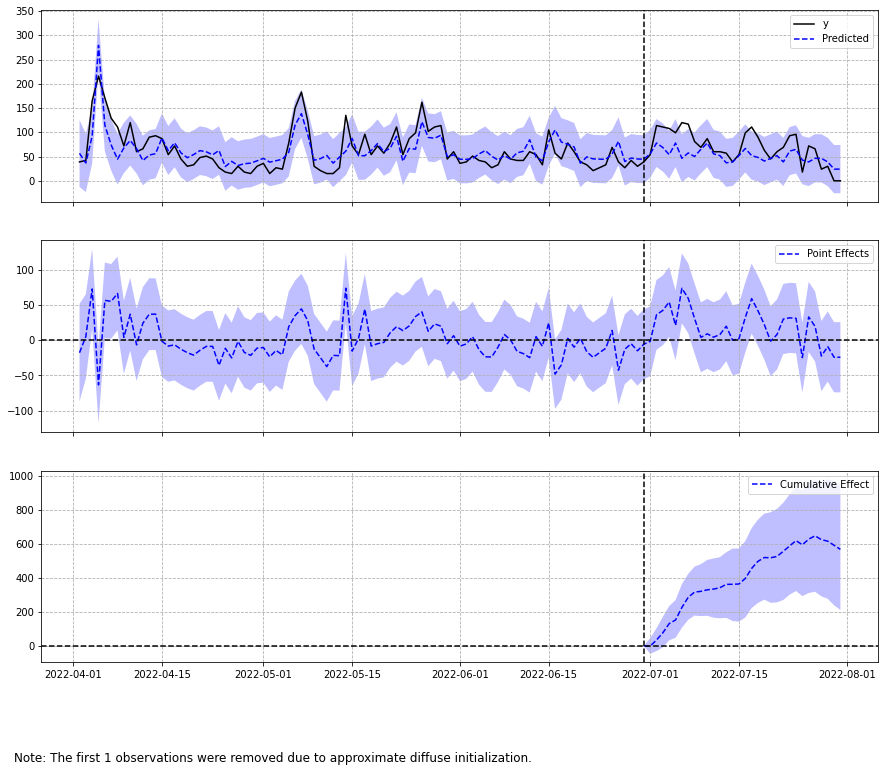

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 69.87. By contrast, in the absence of an
intervention, we would have expected an average response of 51.58.
The 95% interval of this counterfactual prediction is [39.43, 63.09].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 18.29 with a 95% interval of
[6.79, 30.44]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2166.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1599.13. The 95% interval of this prediction is [1222.35, 1955.66].


The above results are given in terms of absolute numbers. In relative
terms, the response vari

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


------------ Belo Horizonte ------------
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    69.87              2166.0
Prediction (s.d.)         40.17 (5.2)        1245.31 (161.19)
95% CI                    [30.23, 50.61]     [937.07, 1568.92]

Absolute effect (s.d.)    29.7 (5.2)         920.69 (161.19)
95% CI                    [19.26, 39.64]     [597.08, 1228.93]

Relative effect (s.d.)    73.93% (12.94%)    73.93% (12.94%)
95% CI                    [47.95%, 98.68%]   [47.95%, 98.68%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


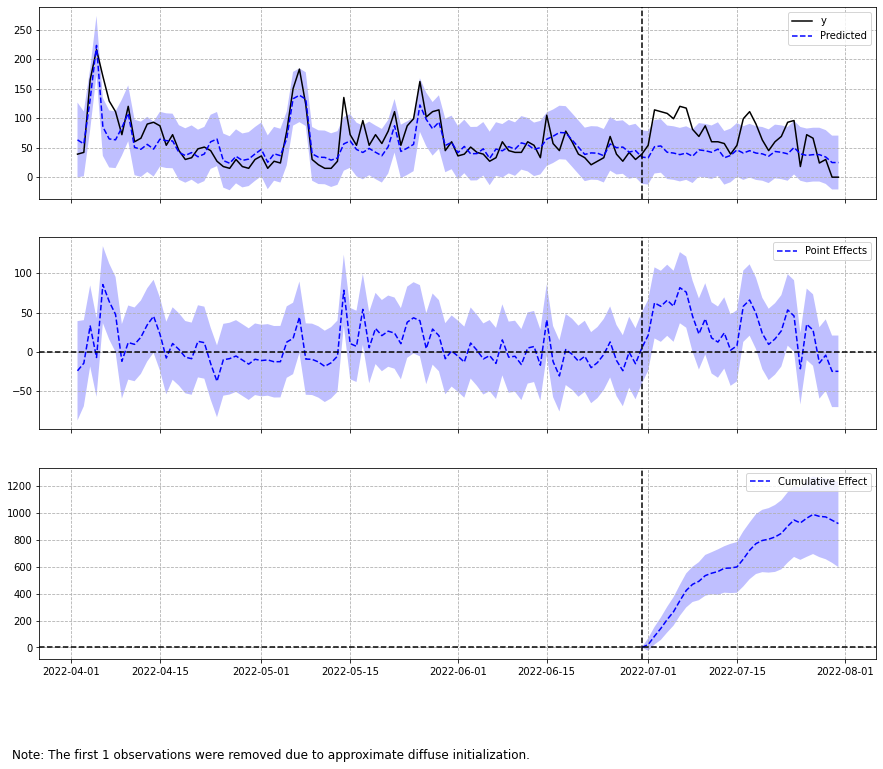

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 69.87. By contrast, in the absence of an
intervention, we would have expected an average response of 40.17.
The 95% interval of this counterfactual prediction is [30.23, 50.61].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 29.7 with a 95% interval of
[19.26, 39.64]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2166.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1245.31. The 95% interval of this prediction is [937.07, 1568.92].


The above results are given in terms of absolute numbers. In relative
terms, the response varia

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


------------ Curitiba ------------
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    69.87              2166.0
Prediction (s.d.)         40.5 (5.73)        1255.41 (177.49)
95% CI                    [28.81, 51.26]     [893.26, 1589.02]

Absolute effect (s.d.)    29.37 (5.73)       910.59 (177.49)
95% CI                    [18.61, 41.06]     [576.98, 1272.74]

Relative effect (s.d.)    72.53% (14.14%)    72.53% (14.14%)
95% CI                    [45.96%, 101.38%]  [45.96%, 101.38%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


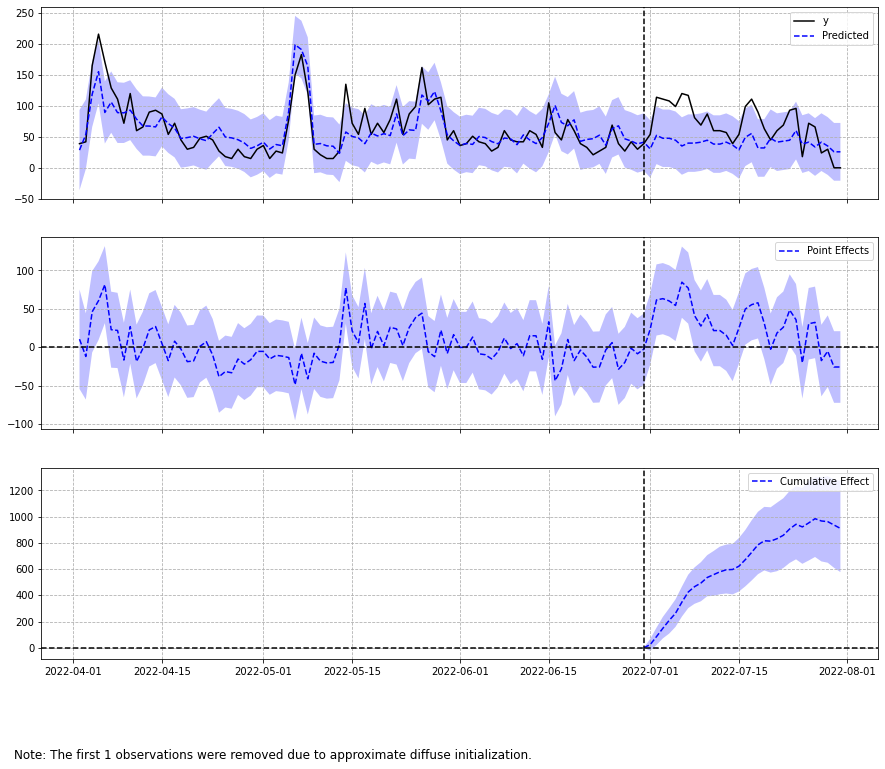

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 69.87. By contrast, in the absence of an
intervention, we would have expected an average response of 40.5.
The 95% interval of this counterfactual prediction is [28.81, 51.26].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 29.37 with a 95% interval of
[18.61, 41.06]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2166.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1255.41. The 95% interval of this prediction is [893.26, 1589.02].


The above results are given in terms of absolute numbers. In relative
terms, the response varia

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


------------ Recife ------------
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    69.87              2166.0
Prediction (s.d.)         37.56 (6.22)       1164.31 (192.68)
95% CI                    [25.06, 49.43]     [776.93, 1532.21]

Absolute effect (s.d.)    32.31 (6.22)       1001.69 (192.68)
95% CI                    [20.44, 44.81]     [633.79, 1389.07]

Relative effect (s.d.)    86.03% (16.55%)    86.03% (16.55%)
95% CI                    [54.44%, 119.3%]   [54.44%, 119.3%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


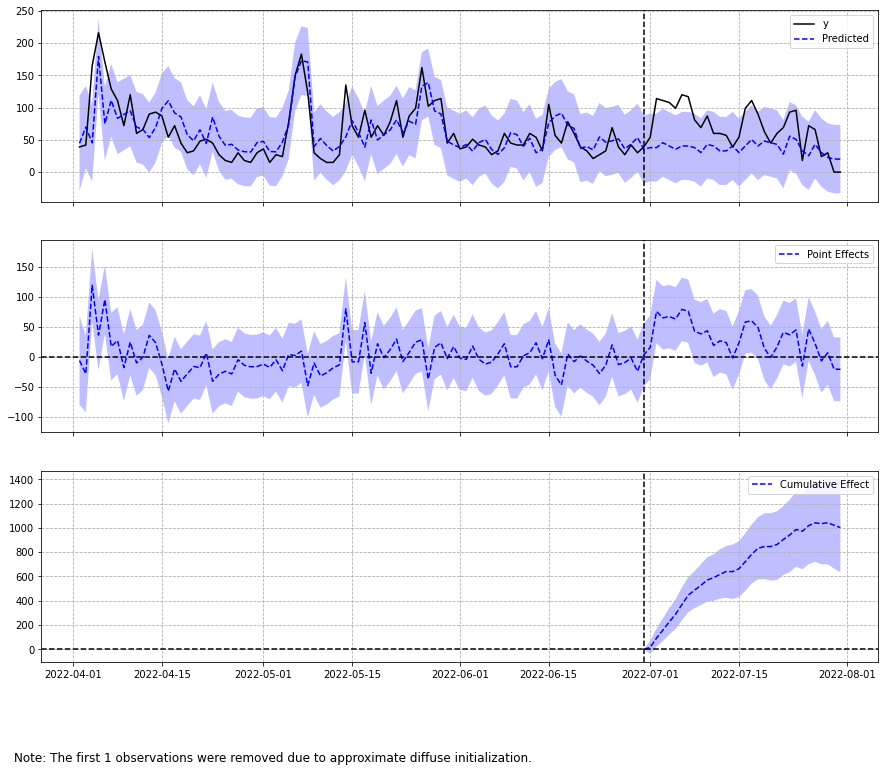

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 69.87. By contrast, in the absence of an
intervention, we would have expected an average response of 37.56.
The 95% interval of this counterfactual prediction is [25.06, 49.43].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 32.31 with a 95% interval of
[20.44, 44.81]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2166.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1164.31. The 95% interval of this prediction is [776.93, 1532.21].


The above results are given in terms of absolute numbers. In relative
terms, the response vari

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


------------ Porto Alegre ------------
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    69.87              2166.0
Prediction (s.d.)         54.66 (5.7)        1694.46 (176.57)
95% CI                    [43.37, 65.69]     [1344.35, 2036.49]

Absolute effect (s.d.)    15.21 (5.7)        471.54 (176.57)
95% CI                    [4.18, 26.5]       [129.51, 821.65]

Relative effect (s.d.)    27.83% (10.42%)    27.83% (10.42%)
95% CI                    [7.64%, 48.49%]    [7.64%, 48.49%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.7%

For more details run the command: print(impact.summary('report'))


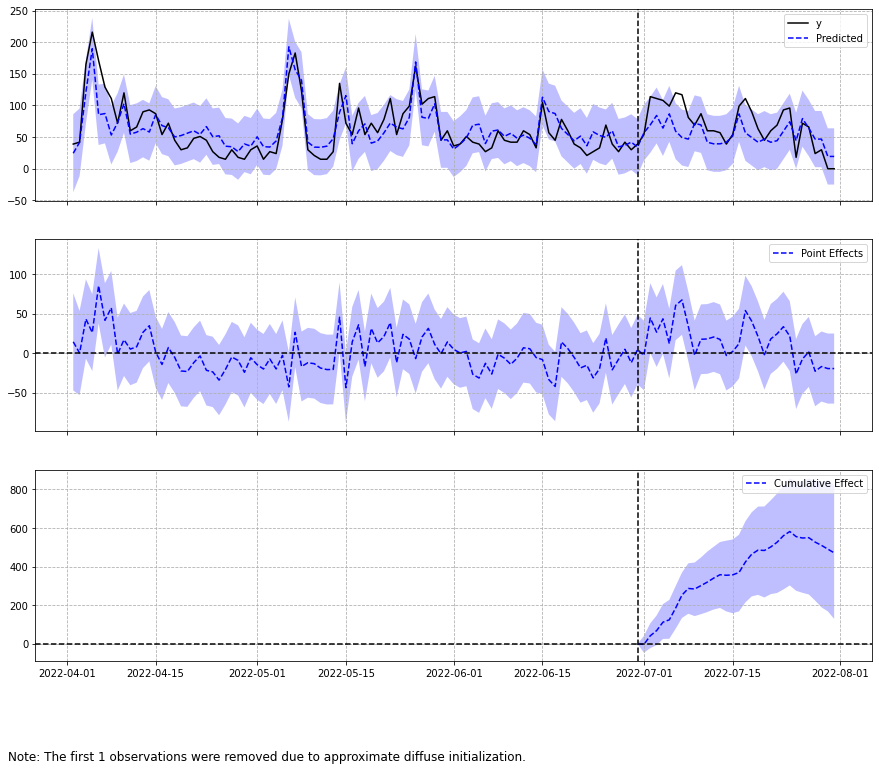

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 69.87. By contrast, in the absence of an
intervention, we would have expected an average response of 54.66.
The 95% interval of this counterfactual prediction is [43.37, 65.69].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 15.21 with a 95% interval of
[4.18, 26.5]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2166.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1694.46. The 95% interval of this prediction is [1344.35, 2036.49].


The above results are given in terms of absolute numbers. In relative
terms, the response varia

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


------------ Campinas ------------
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    69.87              2166.0
Prediction (s.d.)         42.65 (5.34)       1322.27 (165.59)
95% CI                    [32.54, 53.48]     [1008.74, 1657.84]

Absolute effect (s.d.)    27.22 (5.34)       843.73 (165.59)
95% CI                    [16.39, 37.33]     [508.16, 1157.26]

Relative effect (s.d.)    63.81% (12.52%)    63.81% (12.52%)
95% CI                    [38.43%, 87.52%]   [38.43%, 87.52%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


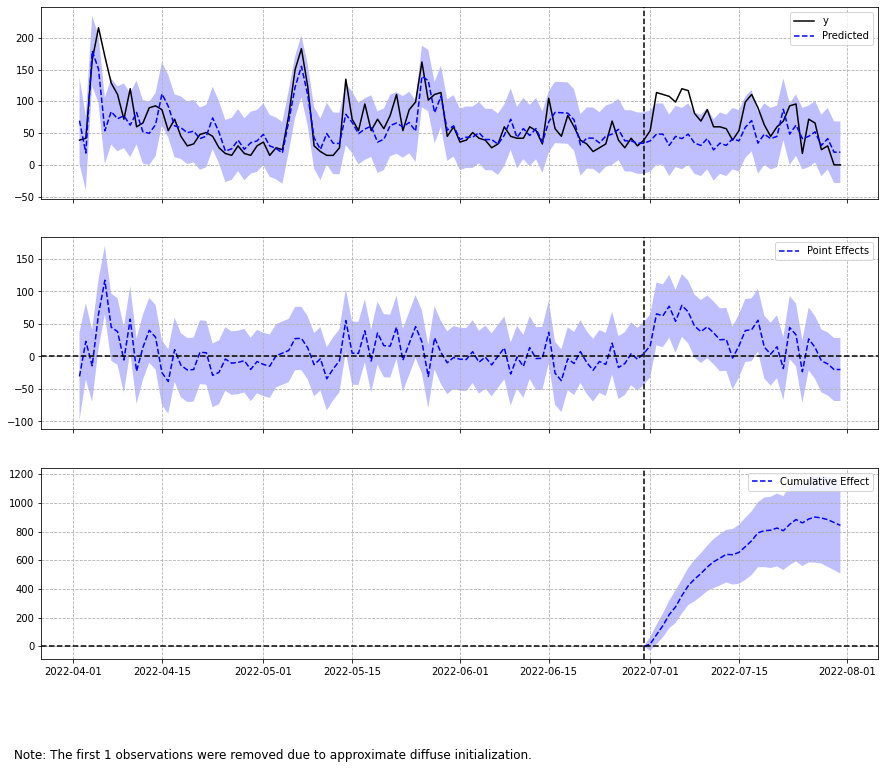

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 69.87. By contrast, in the absence of an
intervention, we would have expected an average response of 42.65.
The 95% interval of this counterfactual prediction is [32.54, 53.48].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 27.22 with a 95% interval of
[16.39, 37.33]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2166.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1322.27. The 95% interval of this prediction is [1008.74, 1657.84].


The above results are given in terms of absolute numbers. In relative
terms, the response var

In [ ]:
#@title Texto de título padrão

df_teste_controle = pd.DataFrame()
for cidade in cidadesSimilares:

  df_teste_controle = timeSeries[cidade].append(timeSeries['Salvador']).reset_index(drop=True)
  df_teste_controle = df_teste_controle.pivot(index = 'DATA', columns='city', values='meta25')
  df_teste_controle =  df_teste_controle[['Salvador', cidade]]
  df_teste_controle = df_teste_controle.sort_values(by='DATA',ascending=True)

  #print( df_teste_controle)

  ci = CausalImpact(df_teste_controle, pre_period, post_period, prior_level_sd=0.01)

  print('------------', cidade, '------------')

  print( ci.summary ())
  ci.plot()
  print(ci.summary(output='report'))


  print('-----------------------------------')